# Traffic Demand Dataset:

Data Schema (Field & Description):

	- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
    - day: the value indicates the sequential order and not a particular day of the month
    - timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
    - demand: aggregated demand normalised to be in the range [0,1]

The dataset can be downloaded [here (140MB CSV file)](https://msftgrab.z23.web.core.windows.net/traffic/training.csv).

# Problem Statements:
 
The challenge targets to improve the traffic condition for road network in Southeast Asia by leveraging Grab booking demand data, which hinders mobility and economic growth. Problem statements including:

  1. Which areas have high / low traffic demand? 
  2. How does regional traffic demand change according to day / time?
  3. Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

In [ ]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib
import platform

message="        Versions        "
print("*"*len(message))
print(message)
print("*"*len(message))
print("Scikit-learn version={}".format(sklearn.__version__))
print("Numpy version={}".format(np.__version__))
print("Pandas version={}".format(pd.__version__))
print("Matplotlib version={}".format(matplotlib.__version__))
print("Python version={}".format(platform.python_version()))

************************
        Versions        
************************
Scikit-learn version=0.22.2.post1
Numpy version=1.18.5
Pandas version=1.1.4
Matplotlib version=3.2.2
Python version=3.6.9


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Mount drive to get access to the data files
# only run this if using google collab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change directory to be in the project folder
# only run this if using google collab
%cd '/content/drive/My Drive/SP_Stuff/Grab_Data_Sci_Challenge/'
!ls

/content/drive/My Drive/SP_Stuff/Grab_Data_Sci_Challenge
Grab_Data_Sci_Challenge.ipynb  time_series_gbr.pkl  training_filled.csv


Loading the already filled dataset

In [ ]:
training_data = pd.read_csv("training_filled.csv")
training_data.head(10 )

,geohash6,day,timestamp,demand,lon,lat
0,qp03wc,1,20:0,0.004959,90.653687,-5.353088
1,qp03wc,1,14:30,0.272885,90.653687,-5.353088
2,qp03wc,1,6:15,0.308053,90.653687,-5.353088
3,qp03wc,1,5:0,0.253679,90.653687,-5.353088
4,qp03wc,1,4:0,0.267803,90.653687,-5.353088
5,qp03wc,1,12:15,0.515115,90.653687,-5.353088
6,qp03wc,1,3:30,0.187321,90.653687,-5.353088
7,qp03wc,1,20:45,0.005720,90.653687,-5.353088
8,qp03wc,1,22:15,0.099461,90.653687,-5.353088
9,qp03wc,1,9:15,0.402417,90.653687,-5.353088


## Getting Region 1 data

In [ ]:
 # getting Region 1 data 
region1 = training_data[training_data['lat'] >= -5.40]
region1 = region1[region1['lat'] <= -5.30]
region1 = region1[region1['lon'] >= 90.60]
region1 = region1[region1['lon'] <= 90.75]
region1

,geohash6,day,timestamp,demand,lon,lat
0,qp03wc,1,20:0,0.004959,90.653687,-5.353088
1,qp03wc,1,14:30,0.272885,90.653687,-5.353088
2,qp03wc,1,6:15,0.308053,90.653687,-5.353088
3,qp03wc,1,5:0,0.253679,90.653687,-5.353088
4,qp03wc,1,4:0,0.267803,90.653687,-5.353088
...,...,...,...,...,...,...
7319995,qp098v,61,19:45,0.000000,90.741577,-5.331116
7319996,qp098v,61,19:0,0.000000,90.741577,-5.331116
7319997,qp098v,61,0:0,0.000000,90.741577,-5.331116
7319998,qp098v,61,17:30,0.000000,90.741577,-5.331116


## Data preparation (Sliding Window)

In [ ]:
# convert the timestamps to datetime
region1["timestamp"] =  pd.to_datetime(region1["timestamp"], format='%H:%M').dt.time

region1

,geohash6,day,timestamp,demand,lon,lat
0,qp03wc,1,20:00:00,0.004959,90.653687,-5.353088
1,qp03wc,1,14:30:00,0.272885,90.653687,-5.353088
2,qp03wc,1,06:15:00,0.308053,90.653687,-5.353088
3,qp03wc,1,05:00:00,0.253679,90.653687,-5.353088
4,qp03wc,1,04:00:00,0.267803,90.653687,-5.353088
...,...,...,...,...,...,...
7319995,qp098v,61,19:45:00,0.000000,90.741577,-5.331116
7319996,qp098v,61,19:00:00,0.000000,90.741577,-5.331116
7319997,qp098v,61,00:00:00,0.000000,90.741577,-5.331116
7319998,qp098v,61,17:30:00,0.000000,90.741577,-5.331116


We would be using the data from one geohash that has the highest mean demand from region 1 to train the regression models since we are predicting on high demand

Note that the model would be trained on every timestamp of every of the 61 days

In [ ]:
region1.groupby("geohash6")["demand"].mean().sort_values(ascending=False)

geohash6
qp03xx    0.751653
qp03xw    0.745806
qp03yb    0.694499
qp03xm    0.680359
qp03wz    0.677979
            ...   
qp03qp    0.000399
qp03y4    0.000225
qp03vc    0.000171
qp098v    0.000083
qp03vf    0.000081
Name: demand, Length: 217, dtype: float64

In [ ]:
high_demand_geohash = region1[region1["geohash6"] == "qp03xx"]

# sort the values by day and timestamp

high_demand_geohash = high_demand_geohash.sort_values(["day", "timestamp"],ascending=True)

In [ ]:
high_demand_geohash["timestamp"] = high_demand_geohash["timestamp"].apply(lambda x: x.strftime('%H:%M'))
high_demand_geohash.index = np.arange(0, len(high_demand_geohash))
high_demand_geohash

,geohash6,day,timestamp,demand,lon,lat
0,qp03xx,1,00:00,0.320478,90.686646,-5.320129
1,qp03xx,1,00:15,0.351964,90.686646,-5.320129
2,qp03xx,1,00:30,0.386225,90.686646,-5.320129
3,qp03xx,1,00:45,0.357434,90.686646,-5.320129
4,qp03xx,1,01:00,0.376079,90.686646,-5.320129
...,...,...,...,...,...,...
5851,qp03xx,61,22:45,0.188155,90.686646,-5.320129
5852,qp03xx,61,23:00,0.167299,90.686646,-5.320129
5853,qp03xx,61,23:15,0.181768,90.686646,-5.320129
5854,qp03xx,61,23:30,0.230112,90.686646,-5.320129


Let's use the sliding window approach to restructure the time series into supervised learning problem

The reason for this is so that we can use traditional ML models to do the forecasting

For example, what the sliding window does is convert the time series, which look like this:

| Time   | Measure |
| -------| ------- |
| 1      | 100     |
| 2      | 110     |
| 3      | 108     |
| 4      | 115     |
| 5      | 120     |

and restructured into this:

| X (feature)    | y (labels) |
| -------        | -------    |
| ?              | 100        |
| 100            | 110        |
| 110            | 108        |
| 108            | 115        |
| 115            | 120        |
| 120            | ?          |

The feature, X is the previous time step and the next time step is the label, y

Using the sliding window, the order of the time series demand data is preserved, while allowing for traditional supervised learning models to be used for time series

In our case, we would do a sliding window step of 1, due to forecasting of the next 15 minutes

Note that we would be removing the first and last row of the transformed time data, due to not being able to know the previous time step of the first time step (for the first row) and not knowing the next time step for the last row


In [87]:
high_demand_geohash[["timestamp", "demand"]]

,timestamp,demand
0,00:00,0.320478
1,00:15,0.351964
2,00:30,0.386225
3,00:45,0.357434
4,01:00,0.376079
...,...,...
5851,22:45,0.188155
5852,23:00,0.167299
5853,23:15,0.181768
5854,23:30,0.230112


In [ ]:
X_feature = pd.Series(high_demand_geohash["demand"].shift(), name="X")
# Remove the first NaN
X_feature = X_feature.drop([0])
X_feature

1       0.320478
2       0.351964
3       0.386225
4       0.357434
5       0.376079
          ...   
5851    0.190247
5852    0.188155
5853    0.167299
5854    0.181768
5855    0.230112
Name: X, Length: 5855, dtype: float64

In [ ]:
y_label = pd.Series(high_demand_geohash["demand"], name="y")
y_label = y_label.drop([0])
y_label

1       0.351964
2       0.386225
3       0.357434
4       0.376079
5       0.432797
          ...   
5851    0.188155
5852    0.167299
5853    0.181768
5854    0.230112
5855    0.212988
Name: y, Length: 5855, dtype: float64

In [ ]:
restructured_data = pd.concat([X_feature, y_label], axis=1)
restructured_data

,X,y
1,0.320478,0.351964
2,0.351964,0.386225
3,0.386225,0.357434
4,0.357434,0.376079
5,0.376079,0.432797
...,...,...
5851,0.190247,0.188155
5852,0.188155,0.167299
5853,0.167299,0.181768
5854,0.181768,0.230112


In [ ]:
# Split the training data into 80% training, 20% test
training = restructured_data.iloc[:4685,:]
testing = restructured_data.iloc[4685:,:]

In [ ]:
training

,X,y
1,0.320478,0.351964
2,0.351964,0.386225
3,0.386225,0.357434
4,0.357434,0.376079
5,0.376079,0.432797
...,...,...
4681,0.277573,0.166008
4682,0.166008,0.174010
4683,0.174010,0.217608
4684,0.217608,0.211948


In [ ]:
testing

,X,y
4686,0.139234,0.117363
4687,0.117363,0.109064
4688,0.109064,0.186422
4689,0.186422,0.131396
4690,0.131396,0.137134
...,...,...
5851,0.190247,0.188155
5852,0.188155,0.167299
5853,0.167299,0.181768
5854,0.181768,0.230112


In [ ]:
X_train = training["X"].values.reshape(-1, 1)
y_train = training["y"].values

X_test = testing["X"].values.reshape(-1, 1)
y_test = testing["y"].values

## Model Training

Due to the no free lunch theorem, we would have to try an array of regressors to determine which is best for the problem. 

As such, we would be using:
- Support Vector Regressor
- K-Nearest Neighbour Regressor
- Decision Trees Regressor
- Random Forest Regressor
- Multi Layer Perceptron or Artificial Neural Network
- Linear Regression
- Gradient Boosting Regressor (GBR)

In [ ]:
# array to store all the different dicts of r2 scores of different models
models_r2_scores = []

# Getting all the different regressors
# SVR
from sklearn.svm import SVR
svr_model = SVR()

# KNN
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor() 

# Decision Tree Regressor
from sklearn import tree
decision_tree_model = tree.DecisionTreeRegressor(random_state=1)

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=1)

# MLP
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(random_state=1)

# Linear Regression
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
gbr_model = GradientBoostingRegressor(random_state=1)

# array to store all the models
models = [svr_model, knn_model, decision_tree_model, rf_model, mlp_model, lr_model, gbr_model]

# array containing all the names of models in order
model_names = ["SVR", "KNN", "Decision Tree", "Random Forest", "MLP", "Linear Regression", "GBR"]

for i in range(len(models)):
  # Train each of the models
  models[i].fit(X_train, y_train)
  # Generate the name of the model
  models_r2_scores.append({
    "regressor": model_names[i],
    "training": models[i].score(X_train, y_train),
    "test": models[i].score(X_test, y_test)
  })

In [ ]:
# Display the summary of r2 scores for all the models
# dataframe to store the summary of scores
summary_scores = pd.DataFrame(models_r2_scores)

# Create new column to find difference in r2 scores of models on training set vs test set
summary_scores["diff"] = summary_scores["training"] - summary_scores["test"]
summary_scores.sort_values(["training"], ascending=False)

,regressor,training,test,diff
2,Decision Tree,0.994205,0.958981,0.035224
3,Random Forest,0.989825,0.969631,0.020194
1,KNN,0.977169,0.974262,0.002907
6,GBR,0.975853,0.977575,-0.001721
5,Linear Regression,0.972135,0.978245,-0.006110
4,MLP,0.972053,0.978028,-0.005976
0,SVR,0.924549,0.919645,0.004904


All the models seem to be good predictors with above 0.90 training and test accuracies, however the difference between the training and test scores were the smallest for the GBR, which suggest that this model would be the  best generaliser hence we would use that model as our final one

Let's see the predictions of demands made by the GBR

In [54]:
# load the saved model
import pickle
gbr_model = pickle.loads(open("./time_series_gbr.pkl", "rb").read())

In [55]:
# get all the predictions of demand by GBR
preds = gbr_model.predict(high_demand_geohash["demand"].values.reshape(-1, 1))

In [56]:
# add the predictions to the high demand geohash
high_demand_geohash["preds"] = pd.Series(preds).shift()

In [57]:
high_demand_geohash

,geohash6,day,timestamp,demand,lon,lat,preds
0,qp03xx,1,00:00,0.320478,90.686646,-5.320129,NaN
1,qp03xx,1,00:15,0.351964,90.686646,-5.320129,0.316166
2,qp03xx,1,00:30,0.386225,90.686646,-5.320129,0.345264
3,qp03xx,1,00:45,0.357434,90.686646,-5.320129,0.390756
4,qp03xx,1,01:00,0.376079,90.686646,-5.320129,0.367595
...,...,...,...,...,...,...,...
5851,qp03xx,61,22:45,0.188155,90.686646,-5.320129,0.193616
5852,qp03xx,61,23:00,0.167299,90.686646,-5.320129,0.193616
5853,qp03xx,61,23:15,0.181768,90.686646,-5.320129,0.170722
5854,qp03xx,61,23:30,0.230112,90.686646,-5.320129,0.187587


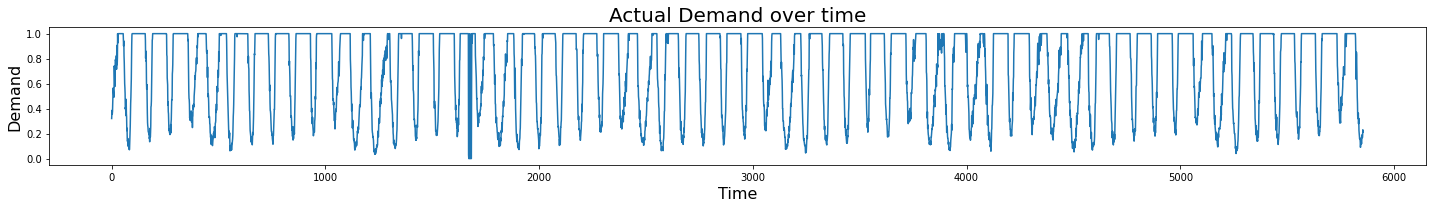

In [58]:
plt.figure(figsize=(20, 3))
ax = sns.lineplot(x=np.arange(0, len(high_demand_geohash)), y="demand", data=high_demand_geohash)
# ax.set_xticklabels(ax.get_xticklabels())
# adding the title
plt.title("Actual Demand over time", fontsize=20)
# adding x/y labels
plt.xlabel("Time", fontsize=16)
plt.ylabel("Demand", fontsize=16)
plt.tight_layout()
plt.show()

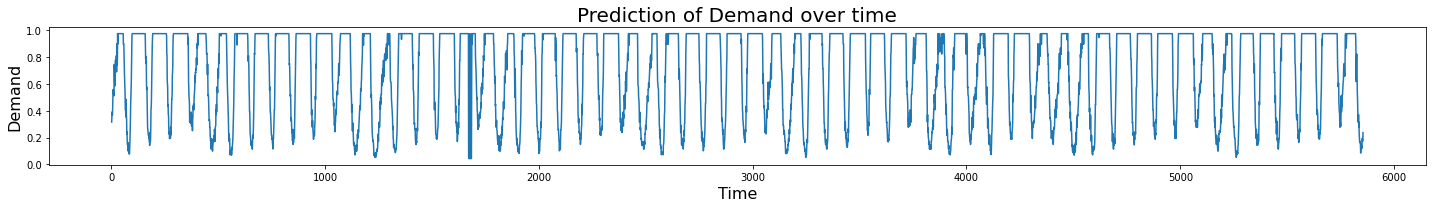

In [59]:
plt.figure(figsize=(20, 3))
ax = sns.lineplot(x=np.arange(0, len(high_demand_geohash)), y="preds", data=high_demand_geohash)
# ax.set_xticklabels(ax.get_xticklabels())
# adding the title
plt.title("Prediction of Demand over time", fontsize=20)
# adding x/y labels
plt.xlabel("Time", fontsize=16)
plt.ylabel("Demand", fontsize=16)
plt.tight_layout()
plt.show()

From the graphs, the GBR seems to predict / forecast all the demand over time almost exactly like the actual demand

Let's test the GBR out by giving it the demand of another geohash

In [60]:
high_demand_geohash_2 = region1[region1["geohash6"] == "qp03w1"]

# sort the values by day and timestamp
high_demand_geohash_2 = high_demand_geohash_2.sort_values(["day", "timestamp"],ascending=True)

In [61]:
high_demand_geohash_2

,geohash6,day,timestamp,demand,lon,lat
2090685,qp03w1,1,00:00:00,0.047240,90.620728,-5.353088
2090616,qp03w1,1,00:15:00,0.084070,90.620728,-5.353088
2090637,qp03w1,1,00:30:00,0.081307,90.620728,-5.353088
2090648,qp03w1,1,00:45:00,0.074663,90.620728,-5.353088
2090670,qp03w1,1,01:00:00,0.071727,90.620728,-5.353088
...,...,...,...,...,...,...
2096395,qp03w1,61,22:45:00,0.036728,90.620728,-5.353088
2096427,qp03w1,61,23:00:00,0.047324,90.620728,-5.353088
2096418,qp03w1,61,23:15:00,0.050498,90.620728,-5.353088
2096406,qp03w1,61,23:30:00,0.049589,90.620728,-5.353088


In [62]:
high_demand_geohash_2["timestamp"] = high_demand_geohash_2["timestamp"].apply(lambda x: x.strftime('%H:%M'))
high_demand_geohash_2.index = np.arange(0, len(high_demand_geohash_2))
high_demand_geohash_2

,geohash6,day,timestamp,demand,lon,lat
0,qp03w1,1,00:00,0.047240,90.620728,-5.353088
1,qp03w1,1,00:15,0.084070,90.620728,-5.353088
2,qp03w1,1,00:30,0.081307,90.620728,-5.353088
3,qp03w1,1,00:45,0.074663,90.620728,-5.353088
4,qp03w1,1,01:00,0.071727,90.620728,-5.353088
...,...,...,...,...,...,...
5851,qp03w1,61,22:45,0.036728,90.620728,-5.353088
5852,qp03w1,61,23:00,0.047324,90.620728,-5.353088
5853,qp03w1,61,23:15,0.050498,90.620728,-5.353088
5854,qp03w1,61,23:30,0.049589,90.620728,-5.353088


In [63]:
# get all the predictions of demand by GBR
preds_2 = gbr_model.predict(high_demand_geohash_2["demand"].values.reshape(-1, 1))

In [64]:
# add the predictions to the high demand geohash
high_demand_geohash_2["preds"] = pd.Series(preds_2).shift()

In [65]:
high_demand_geohash_2

,geohash6,day,timestamp,demand,lon,lat,preds
0,qp03w1,1,00:00,0.047240,90.620728,-5.353088,NaN
1,qp03w1,1,00:15,0.084070,90.620728,-5.353088,0.051142
2,qp03w1,1,00:30,0.081307,90.620728,-5.353088,0.088871
3,qp03w1,1,00:45,0.074663,90.620728,-5.353088,0.088080
4,qp03w1,1,01:00,0.071727,90.620728,-5.353088,0.081531
...,...,...,...,...,...,...,...
5851,qp03w1,61,22:45,0.036728,90.620728,-5.353088,0.043379
5852,qp03w1,61,23:00,0.047324,90.620728,-5.353088,0.052285
5853,qp03w1,61,23:15,0.050498,90.620728,-5.353088,0.051142
5854,qp03w1,61,23:30,0.049589,90.620728,-5.353088,0.063476


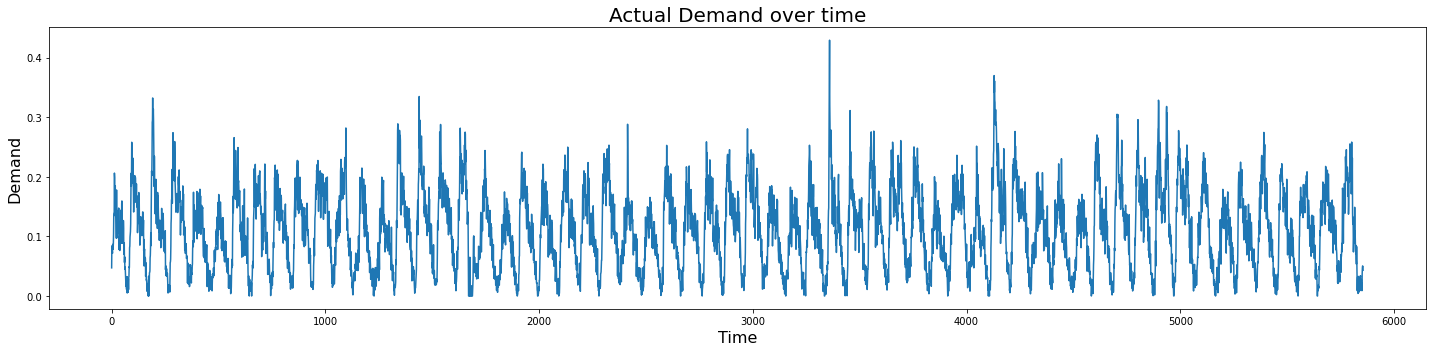

In [88]:
plt.figure(figsize=(20, 5))
ax = sns.lineplot(x=np.arange(0, len(high_demand_geohash_2)), y="demand", data=high_demand_geohash_2)
# adding the title
plt.title("Actual Demand over time", fontsize=20)
# adding x/y labels
plt.xlabel("Time", fontsize=16)
plt.ylabel("Demand", fontsize=16)
plt.tight_layout()
plt.show()

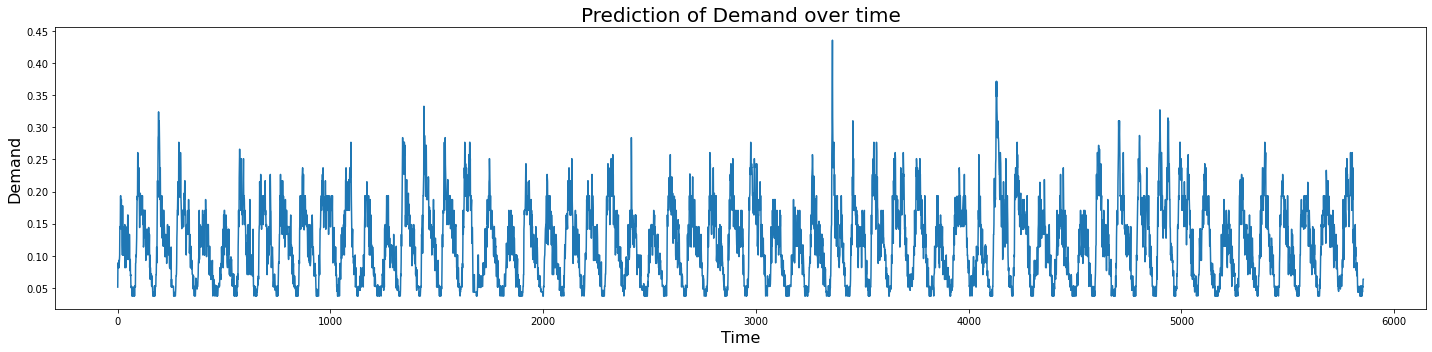

In [67]:
plt.figure(figsize=(20, 5))
ax = sns.lineplot(x=np.arange(0, len(high_demand_geohash_2)), y="preds", data=high_demand_geohash_2)
# adding the title
plt.title("Prediction of Demand over time", fontsize=20)
# adding x/y labels
plt.xlabel("Time", fontsize=16)
plt.ylabel("Demand", fontsize=16)
plt.tight_layout()
plt.show()

Again, the GBR seems to be accurately forecasting the time series of this geohash accurately. Let's see how the model would fare on a geohash with lower demand

In [68]:
low_demand_geohash = training_data[training_data["geohash6"] == "qp03qr"]

In [69]:
low_demand_geohash

,geohash6,day,timestamp,demand,lon,lat
4772640,qp03qr,1,20:0,0.000000,90.631714,-5.364075
4772641,qp03qr,1,14:30,0.010191,90.631714,-5.364075
4772642,qp03qr,1,6:15,0.015597,90.631714,-5.364075
4772643,qp03qr,1,5:0,0.010706,90.631714,-5.364075
4772644,qp03qr,1,4:0,0.013161,90.631714,-5.364075
...,...,...,...,...,...,...
4778491,qp03qr,61,19:45,0.000000,90.631714,-5.364075
4778492,qp03qr,61,19:0,0.000000,90.631714,-5.364075
4778493,qp03qr,61,0:0,0.008734,90.631714,-5.364075
4778494,qp03qr,61,17:30,0.000000,90.631714,-5.364075


In [72]:
low_demand_geohash["timestamp"] =  pd.to_datetime(low_demand_geohash["timestamp"], format='%H:%M').dt.time

low_demand_geohash

,geohash6,day,timestamp,demand,lon,lat
4772733,qp03qr,1,00:00:00,0.000000,90.631714,-5.364075
4772664,qp03qr,1,00:15:00,0.000000,90.631714,-5.364075
4772685,qp03qr,1,00:30:00,0.000000,90.631714,-5.364075
4772696,qp03qr,1,00:45:00,0.016894,90.631714,-5.364075
4772655,qp03qr,1,10:00:00,0.000000,90.631714,-5.364075
...,...,...,...,...,...,...
4778465,qp03qr,61,08:45:00,0.017994,90.631714,-5.364075
4778423,qp03qr,61,09:00:00,0.029963,90.631714,-5.364075
4778409,qp03qr,61,09:15:00,0.019211,90.631714,-5.364075
4778430,qp03qr,61,09:30:00,0.003758,90.631714,-5.364075


In [73]:
# sort the values by day and timestamp
low_demand_geohash = low_demand_geohash.sort_values(["day", "timestamp"],ascending=True)

In [74]:
low_demand_geohash["timestamp"] = low_demand_geohash["timestamp"].apply(lambda x: x.strftime('%H:%M'))
low_demand_geohash.index = np.arange(0, len(low_demand_geohash))
low_demand_geohash

,geohash6,day,timestamp,demand,lon,lat
0,qp03qr,1,00:00,0.000000,90.631714,-5.364075
1,qp03qr,1,00:15,0.000000,90.631714,-5.364075
2,qp03qr,1,00:30,0.000000,90.631714,-5.364075
3,qp03qr,1,00:45,0.016894,90.631714,-5.364075
4,qp03qr,1,01:00,0.012177,90.631714,-5.364075
...,...,...,...,...,...,...
5851,qp03qr,61,22:45,0.000000,90.631714,-5.364075
5852,qp03qr,61,23:00,0.000000,90.631714,-5.364075
5853,qp03qr,61,23:15,0.000000,90.631714,-5.364075
5854,qp03qr,61,23:30,0.000000,90.631714,-5.364075


In [75]:
# get all the predictions of demand by GBR
preds_3 = gbr_model.predict(low_demand_geohash["demand"].values.reshape(-1, 1))

In [76]:
# add the predictions to the high demand geohash
low_demand_geohash["preds"] = pd.Series(preds_3).shift()

In [41]:
low_demand_geohash

,geohash6,day,timestamp,demand,lon,lat,preds
0,qp03qr,1,00:00,0.000000,90.631714,-5.364075,NaN
1,qp03qr,1,00:15,0.000000,90.631714,-5.364075,0.142558
2,qp03qr,1,00:30,0.000000,90.631714,-5.364075,0.142558
3,qp03qr,1,00:45,0.016894,90.631714,-5.364075,0.142558
4,qp03qr,1,01:00,0.012177,90.631714,-5.364075,0.026936
...,...,...,...,...,...,...,...
5851,qp03qr,61,22:45,0.000000,90.631714,-5.364075,0.142558
5852,qp03qr,61,23:00,0.000000,90.631714,-5.364075,0.142558
5853,qp03qr,61,23:15,0.000000,90.631714,-5.364075,0.142558
5854,qp03qr,61,23:30,0.000000,90.631714,-5.364075,0.142558


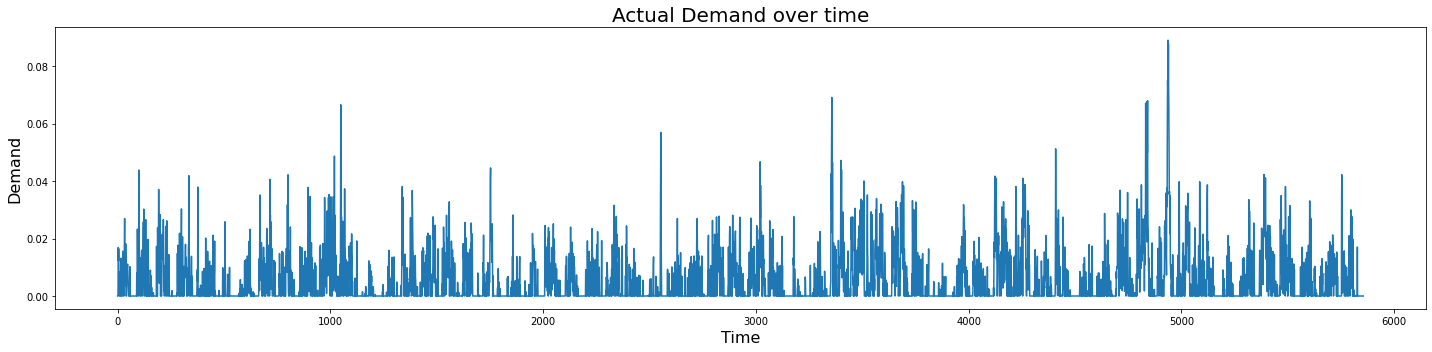

In [77]:
plt.figure(figsize=(20, 5))
ax = sns.lineplot(x=np.arange(0, len(low_demand_geohash)), y="demand", data=low_demand_geohash)
# adding the title
plt.title("Actual Demand over time", fontsize=20)
# adding x/y labels
plt.xlabel("Time", fontsize=16)
plt.ylabel("Demand", fontsize=16)
plt.tight_layout()
plt.show()

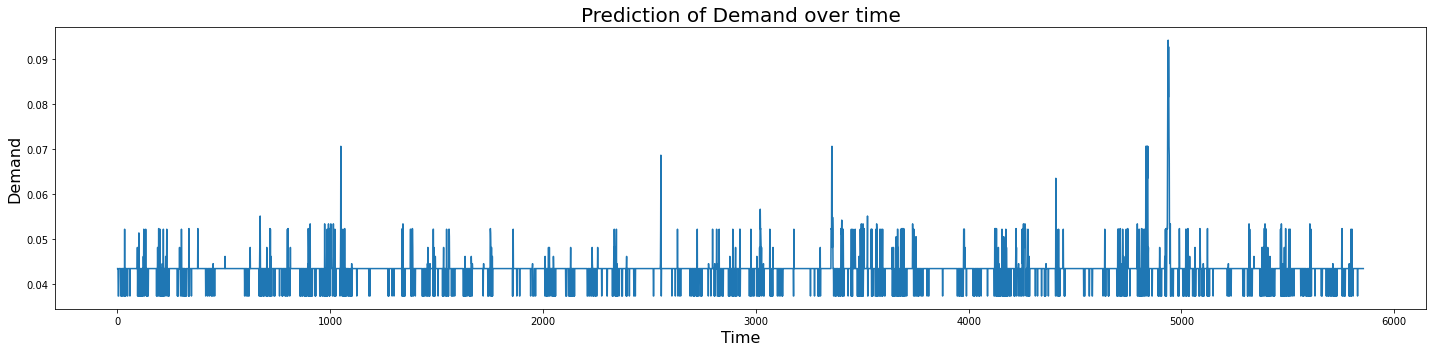

In [78]:
plt.figure(figsize=(20, 5))
ax = sns.lineplot(x=np.arange(0, len(low_demand_geohash)), y="preds", data=low_demand_geohash)
# adding the title
plt.title("Prediction of Demand over time", fontsize=20)
# adding x/y labels
plt.xlabel("Time", fontsize=16)
plt.ylabel("Demand", fontsize=16)
plt.tight_layout()
plt.show()

Now we can see that the model is not able to forecast geohashes for low demand that accurately, as seen from the regions significantly lower demand forecasted for the actual regions low demand.

## Evaluation

Let' use some metrics to evaluate the performance of the model

First, we would use RMSE

In [79]:
from sklearn.metrics import mean_squared_error

# RMSE of the Gradient Boosting Regressor on the training set
rmse_train = mean_squared_error(y_train, gbr_model.predict(X_train), squared=False)

# RMSE of the Gradient Boosting Regressor on the test set
rmse_test = mean_squared_error(y_test, gbr_model.predict(X_test), squared=False)

# print out all the respective RMSE
print(f"Root Mean Square Error of GBR on training set: {rmse_train}")
print(f"Root Mean Square Error of GBR on test set: {rmse_test}")

Root Mean Square Error of GBR on training set: 0.05766612487373278
Root Mean Square Error of GBR on test set: 0.050886765165090574


In [80]:
high_demand_geohash["demand"].describe()

count    5856.000000
mean        0.751653
std         0.327006
min         0.000000
25%         0.445603
50%         1.000000
75%         1.000000
max         1.000000
Name: demand, dtype: float64

The value of the RMSE of 0.054 on the training set and 0.057 on the test set is very small, when comparing those RMSE values to the standard deviation of the demand of the geohash, which is 0.25. 

This shows that the demands predicted do not deviate much from the actual demands. Hence this shows that the model is forecasting demand accurately with low amount of errors

Second, let's see the residual plot

In [81]:
# get all the predictions
y_hat = gbr_model.predict(X_test)
# get all the residuals
residuals = y_test - y_hat
residuals

array([-0.02763112, -0.00797609,  0.07287157, ...,  0.01104608,
        0.04252573, -0.02404413])

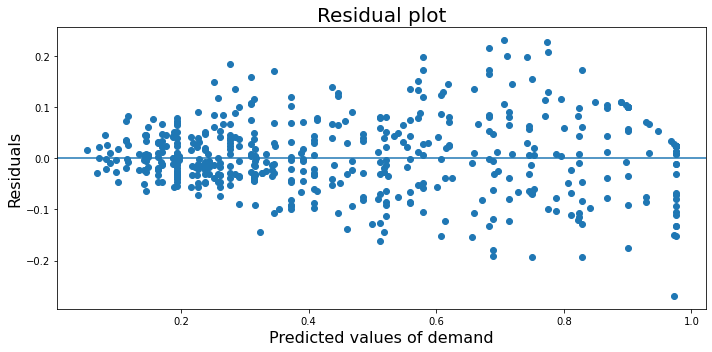

In [82]:
# plot the residual plot
plt.figure(figsize=(10, 5))
plt.scatter(x=y_hat, y=residuals)
plt.axhline(y=0)
# adding the title
plt.title("Residual plot", fontsize=20)
# adding x/y labels
plt.xlabel("Predicted values of demand", fontsize=16)
plt.ylabel("Residuals", fontsize=16)
plt.tight_layout()
plt.show()

Taking into account that the demand is a value between 0 and 1, 

From the residual plot above,

- the data points in the residual plot are symmetrically distributed, tending to cluster towards the middle of the plot.

- the data points are clustered around where y = 0, most of the residuals are within the range of -0.1 to 0.1. 

- there does not seem to have any clear patterns in the plot

- the majority of the predicted values for demand by the GBR is close to the actual demand, as most of the residuals are quite close to 0

The GBR model prediction errors are quite minimal

## Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

In order to do forecasting of the travel demand, the GBR model can be given the demand of the current time and it will output the demand of the next 15 minutes.

The demand given (input) must be a 2-dimensional numpy array. 

The output would be a numpy array containing the predicted demand for next 15 minutes

In [83]:
# Example input
inputs = high_demand_geohash["demand"].values.reshape(-1, 1)
inputs

array([[0.32047768],
       [0.35196357],
       [0.38622463],
       ...,
       [0.18176804],
       [0.23011244],
       [0.21298804]])

In [85]:
# Example output
preds = gbr_model.predict(inputs)
preds

array([0.316166  , 0.34526377, 0.39075649, ..., 0.18758671, 0.23703218,
       0.21529425])

## Saving the model

In [ ]:
!pwd

/content/drive/My Drive/SP_Stuff/Grab_Data_Sci_Challenge


In [ ]:
import pickle
# write the face predictor to disk
dir_path = "./time_series_gbr.pkl"

f = open(dir_path, "wb")
f.write(pickle.dumps(gbr_model))
f.close()


In [ ]:
!ls

Grab_Data_Sci_Challenge.ipynb  time_series_gbr.pkl  training_filled.csv
